## Idea
I want to create a dendogram with pcs as root of it. On each transition to the higher level of that hierarchy, some pcs are aggregated.

In [1139]:
from PCAfold import VQPCA
from PCAfold import get_centroids

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import load_iris
from scipy.cluster.hierarchy import dendrogram


In [1140]:
iris = load_iris()
X = iris.data

In [1141]:
n_points = 2000

# Parameters for cluster 1
mean_local_1 = [50, 0]
covariance_local_1 = np.array([[100, 90], [90, 100]])  # Swap off-diagonal elements

# Parameters for cluster 2
mean_local_2 = [200, -50]
covariance_local_2 = np.array([[100, -90], [-90, 100]])  # Swap off-diagonal elements

# Parameters for cluster 3
mean_local_3 = [100, 150]
covariance_local_3 = np.array([[1, 0], [0, 100]])  # Set off-diagonal element to 0

# Generate samples for each cluster
x_noise_1, y_noise_1 = np.random.multivariate_normal(mean_local_1, covariance_local_1, n_points).T
x_noise_2, y_noise_2 = np.random.multivariate_normal(mean_local_2, covariance_local_2, n_points).T
x_noise_3, y_noise_3 = np.random.multivariate_normal(mean_local_3, covariance_local_3, n_points).T

# Concatenate the data points
x_local = np.concatenate([x_noise_1, x_noise_2, x_noise_3])
y_local = np.concatenate([y_noise_1, y_noise_2, y_noise_3])

Dataset_local = np.hstack((x_local[:, np.newaxis], y_local[:, np.newaxis]))

In [1142]:
# Instantiate VQPCA class object:
vqpca = VQPCA(
    Dataset_local,
    n_clusters=3,
    n_components=1,
    scaling='std',
    idx_init='random',
    max_iter=100,
    tolerance=1.0e-20,
    verbose=True
)

| It.   | Rec. error      | Error conv.? | Cent. conv.? | Cluster 1  | Cluster 2  | Cluster 3  | Time [min]   |
| 1     | 0.14153048      | False        | False        | 1170       | 830        | 4000       | 8e-05        |
| 2     | 0.00923774      | False        | False        | 971        | 1034       | 3995       | 0.00014      |
| 3     | 0.00890467      | False        | False        | 1027       | 1012       | 3961       | 0.00022      |
| 4     | 0.00761938      | False        | False        | 1318       | 895        | 3787       | 0.00028      |
| 5     | 0.00615183      | False        | False        | 1527       | 985        | 3488       | 0.00034      |
| 6     | 0.00527353      | False        | False        | 1592       | 1185       | 3223       | 0.00041      |
| 7     | 0.00487028      | False        | False        | 1572       | 1393       | 3035       | 0.00047      |
| 8     | 0.00471468      | False        | False        | 1560       | 1526       | 2914       | 0.00055

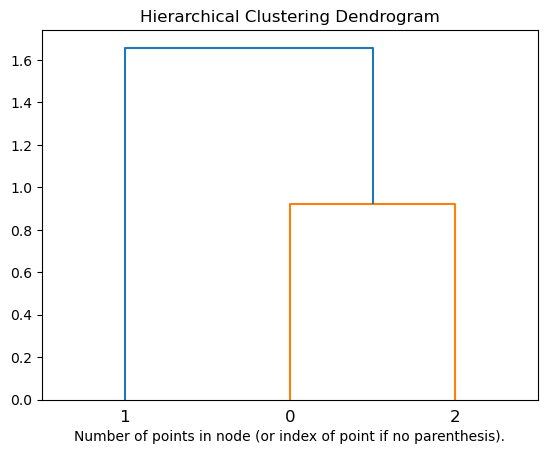

In [1143]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(np.squeeze(np.array(vqpca.A)))
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=2)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()



In [1144]:
#function to create aggregated eigenvectors
def agg_eigenvectors(eigenvectors, children, centroids):
    for child in children:
        agg_row = np.mean(eigenvectors[[child[0], child[1]], :], axis=0).reshape(1, -1)
        eigenvectors = np.vstack([eigenvectors, agg_row])
        agg_cen = np.mean(centroids[[child[0], child[1]], :], axis=0).reshape(1, -1)
        centroids = np.vstack([centroids, agg_cen])
    return eigenvectors, centroids

eigenvectors0 = np.squeeze(np.stack((vqpca.A)))

e, c = agg_eigenvectors(eigenvectors0, model.children_, get_centroids(Dataset_local, vqpca.idx))

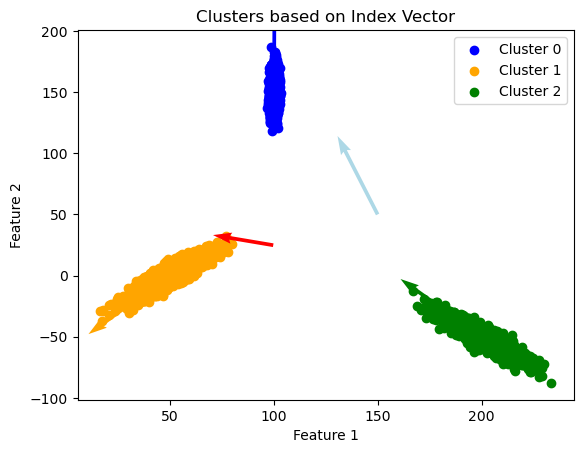

In [1145]:
# Access the VQPCA clustering solution:
idx = vqpca.idx
#pcs = vqpca.A
#print(pcs)

# Separate data points based on cluster index
cluster_0 = Dataset_local[idx == 0]
cluster_1 = Dataset_local[idx == 1]
cluster_2 = Dataset_local[idx == 2]
#cluster_3 = Dataset_local[idx == 3]

# Plot the clusters
plt.scatter(cluster_0[:, 0], cluster_0[:, 1], label='Cluster 0', color='blue')
plt.scatter(cluster_1[:, 0], cluster_1[:, 1], label='Cluster 1', color='orange')
plt.scatter(cluster_2[:, 0], cluster_2[:, 1], label='Cluster 2', color='green')
#plt.scatter(cluster_3[:, 0], cluster_3[:, 1], label='Cluster 3', color='lightblue')

plt.quiver(c[:, 0], c[:, 1], e[:, 0], e[:, 1], color=['blue', 'orange', 'green', 'lightblue', 'red', 'black', 'gray'], scale=5)

#plt.scatter(cluster_3[:, 0], cluster_3[:, 1], label='Cluster 3', color='yellow')

# Add labels and title
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Clusters based on Index Vector')

# Show legend
plt.legend()

# Show the plot
plt.show()